In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.metrics import classification_report

# Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa

# Keras
from keras import models, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3

# Warnings
import warnings
warnings.filterwarnings("ignore")

### Check GPU

In [19]:
# Check for available physical GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # If there are GPUs available, TensorFlow should automatically utilize them
    print("Available GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU(s) available.")

No GPU(s) available.


In [20]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU(s),", len(logical_gpus), "Logical GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [21]:
print(tf.config.list_physical_devices('GPU'))

[]


### Emman Laptop

In [22]:
# Access image directory
root_dir = r"E:\Jean Eileen Magtibay\chexscan\dataset"
train_dir = root_dir + "/train"
valid_dir = root_dir + "/valid"

### Declaration

In [23]:
# Acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

['Normal', 'Pneumonia', 'Tuberculosis']


In [24]:
IMAGE_SIZE = 224
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50

n_classes = len(class_names)
n_classes

3

## Data Generator 

In [25]:
img_size = (IMAGE_SIZE, IMAGE_SIZE)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    rotation_range=30,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1680 images belonging to 3 classes.


In [26]:
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical'
)

Found 420 images belonging to 3 classes.


### Callback

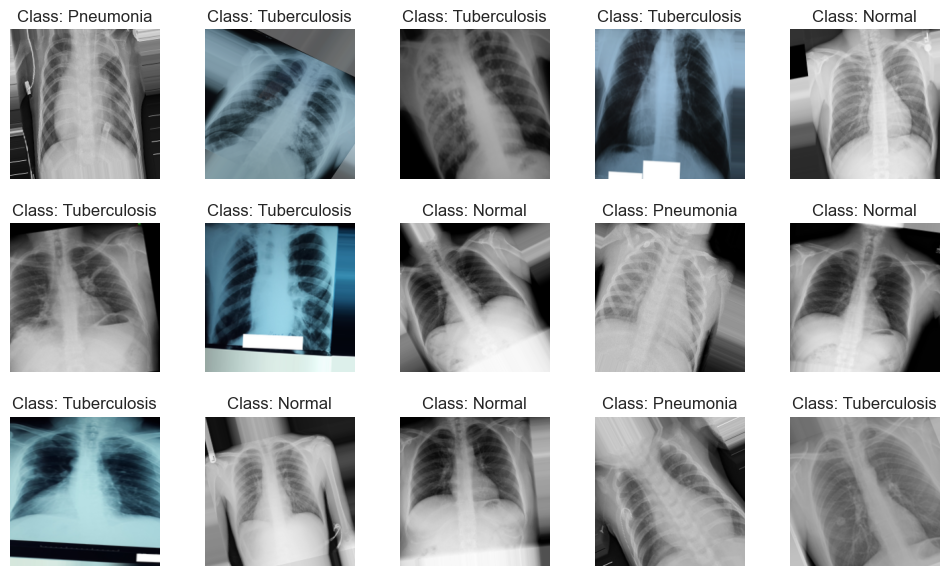

In [27]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])

    # Convert the float target to integer (0 or 1)
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]

    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [28]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
# class MyCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_acc') > 0.99:
#             print("\nReached accuracy threshold! Terminating training.")
#             # self.model.stop_training = False

# my_callback = MyCallback()

#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold_count):
        super(MyCallback, self).__init__()
        self.threshold_count = threshold_count
        self.consecutive_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            self.consecutive_count += 1
            if self.consecutive_count >= self.threshold_count:
                print("\nReached accuracy threshold 3 times! Terminating training.")
                self.model.stop_training = True
        else:
            self.consecutive_count = 0

# Define the callback with the threshold count
my_callback = MyCallback(threshold_count=3)

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss",
                                 patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss',
                             patience=10,
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

# Inception V3

In [29]:
model_inception=InceptionV3(weights='imagenet')
input_layer=layers.Input(shape=(HEIGHT,WIDTH,CHANNELS))
model_inception=InceptionV3(weights='imagenet',input_tensor=input_layer,include_top=False)
last_layer=model_inception.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(n_classes,activation='softmax')(flatten)
model_inception=models.Model(inputs=input_layer,outputs=output_layer)

print("We are making all the layers intrainable except the last layer. \n")
for layer in model_inception.layers[:-1]:
    layer.trainable=False

We are making all the layers intrainable except the last layer. 



In [30]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

CALLBACKS = [my_callback, rop_callback, earlystop_cb]

In [31]:
model_inception.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
# model_inception.summary()

In [32]:
history_inception = model_inception.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    verbose=True,
    validation_data=valid_generator, 
    callbacks=CALLBACKS, 
    epochs=EPOCHS)

Epoch 1/50
53/53 [==============================] - 55s 1s/step - loss: 4.9695 - acc: 0.7577 - f1_score: 0.7579 - val_loss: 0.4614 - val_acc: 0.9286 - val_f1_score: 0.9284
Epoch 2/50
53/53 [==============================] - 55s 1s/step - loss: 1.9796 - acc: 0.8714 - f1_score: 0.8715 - val_loss: 2.2093 - val_acc: 0.8048 - val_f1_score: 0.7870
Epoch 3/50
53/53 [==============================] - 57s 1s/step - loss: 1.9556 - acc: 0.8696 - f1_score: 0.8694 - val_loss: 0.8829 - val_acc: 0.9357 - val_f1_score: 0.9356
Epoch 4/50
53/53 [==============================] - 55s 1s/step - loss: 1.5120 - acc: 0.9060 - f1_score: 0.9060 - val_loss: 0.5211 - val_acc: 0.9452 - val_f1_score: 0.9448
Epoch 5/50
53/53 [==============================] - 55s 1s/step - loss: 1.4469 - acc: 0.9101 - f1_score: 0.9101 - val_loss: 0.8899 - val_acc: 0.9262 - val_f1_score: 0.9244
Epoch 6/50
53/53 [==============================] - 64s 1s/step - loss: 1.2292 - acc: 0.9226 - f1_score: 0.9226 - val_loss: 0.5356 - val_acc

In [33]:
predictions = model_inception.predict(valid_generator)

# Obtain the true labels from the test_generator
true_labels = valid_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97       140
   Pneumonia       0.99      1.00      1.00       140
Tuberculosis       0.96      0.96      0.96       140

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420



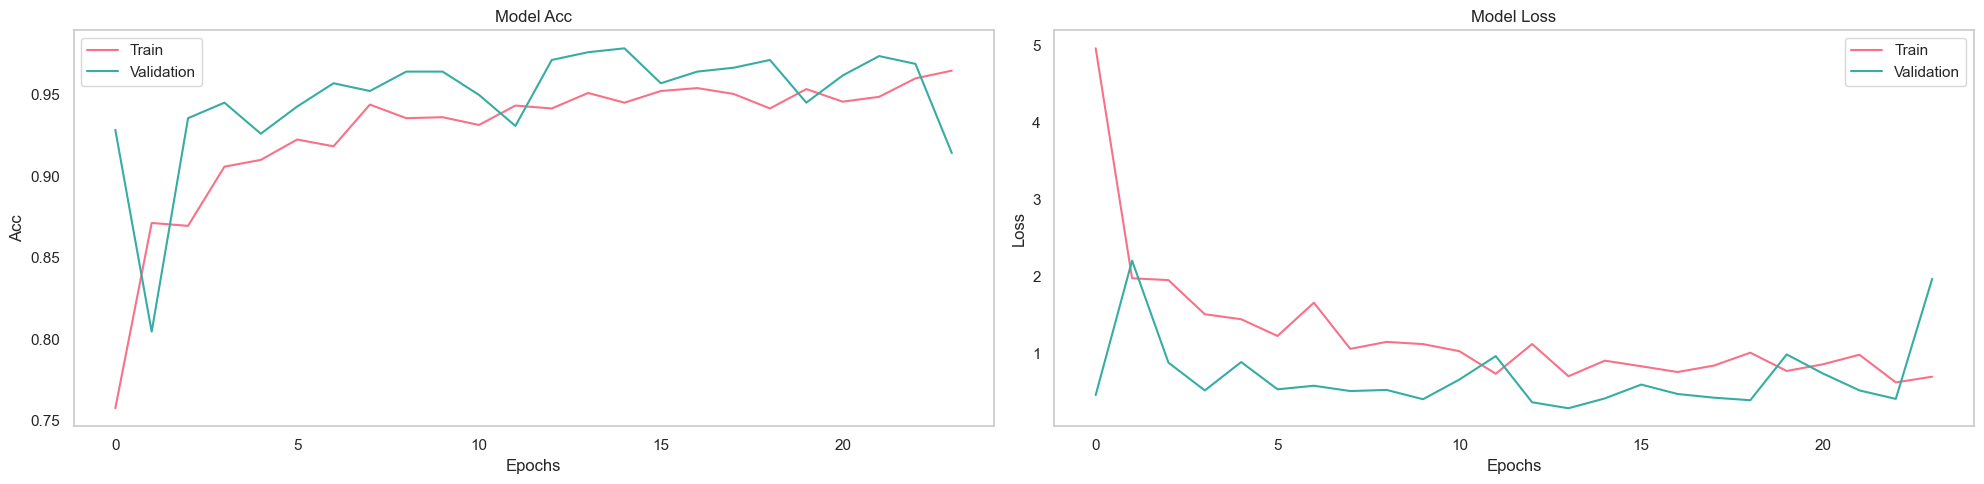

In [34]:
sns.set(style="whitegrid", rc={"axes.grid": False})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_inception.epoch, y=history_inception.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_inception.epoch, y=history_inception.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
plt.show()